# MLZoomcamp 2022 - Session #4 - Homework

Author: José Victor

* Dataset: [Econometric Analysis](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv)

In [1]:
%cd /home/jvictor/vs_code/mlzoomcamp2022_jvscursulim/04-evaluation/data

!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

/home/jvictor/vs_code/mlzoomcamp2022_jvscursulim/04-evaluation/data
--2022-09-26 02:10:14--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.1s    

2022-09-26 02:10:15 (669 KB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression

## Goal

The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`)

## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0.
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`.

In [2]:
TARGET = "card"
train_size = 0.6
val_size = 0.2
test_size = 0.2

In [3]:
df = pd.read_csv("/home/jvictor/vs_code/mlzoomcamp2022_jvscursulim/04-evaluation/data/AER_credit_card_data.csv")
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
df.card = df.card.str.replace("yes", "1")
df.card = df.card.str.replace("no", "0")
df.card = df.card.astype(int)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
cols = [col for col in df.columns if col != TARGET]

X_train, X_test, y_train, y_test = train_test_split(df[cols], 
                                                    df[TARGET], 
                                                    test_size=test_size, 
                                                    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=val_size/(test_size+train_size), 
                                                  random_state=1)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* ( ) `reports`
* ( ) `dependents`
* ( ) `active`
* (X) `share`

In [6]:
cols = ["reports", "dependents", "active", "share"]

for column in cols:
    fpr, tpr, thresholds = roc_curve(y_train, X_train[column])
    auc_score = auc(x=fpr, y=tpr)
    print(f"{column} AUC: {auc_score}")

reports AUC: 0.28333701393106236
dependents AUC: 0.46722427722262094
active AUC: 0.6043173411362006
share AUC: 0.989183643423692


## Training the model

From now on, use these columns only:

In [7]:
COLUMNS = ["reports",
           "age",
           "share",
           "expenditure",
           "dependents",
           "months",
           "majorcards",
           "active",
           "owner",
           "selfemp"]

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

In [8]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)

In [9]:
train_dict = X_train.to_dict(orient="records")
val_dict = X_val.to_dict(orient="records")
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [10]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

* ( ) 0.615
* ( ) 0.515
* ( ) 0.715
* (X) 0.995

In [11]:
y_pred = model.predict(X=X_val)
fpr, tpr, thresholds = roc_curve(y_val.values, y_pred)
auc(fpr, tpr).round(3)

0.974

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curvers intersect?

* ( ) 0.1
* (X) 0.3
* ( ) 0.6
* ( ) 0.8

In [12]:
y_pred = model.predict_proba(X=X_val)[:, 1]
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [13]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

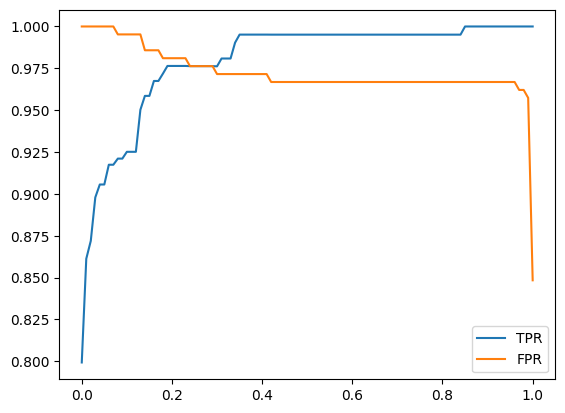

In [14]:
plt.plot(df_scores.threshold, df_scores['p'], label='TPR')
plt.plot(df_scores.threshold, df_scores['r'], label='FPR')
plt.legend()

In [15]:
df_scores[df_scores.p == df_scores.r][["threshold", "p", "r"]]

,threshold,p,r
24,0.24,0.976303,0.976303
25,0.25,0.976303,0.976303
26,0.26,0.976303,0.976303
27,0.27,0.976303,0.976303
28,0.28,0.976303,0.976303
29,0.29,0.976303,0.976303


## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

This is the formula for computing F1:

$F_1 = \frac{2PR}{P+R}$

Where $P$ is precision and $R$ is recall.

Let's compute $F1$ for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold $F1$ is maximal?

* ( ) 0.1
* (X) 0.4
* ( ) 0.6
* ( ) 0.7


In [16]:
df_scores['f1'] = (2*df_scores.p*df_scores.r)/(df_scores.p+df_scores.r)

In [17]:
df_scores[["threshold","f1"]].sort_values(by="f1", ascending=False).head(1)

,threshold,f1
39,0.39,0.983213


## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_split=5, shuffle=True, random_state=1)`

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the AUC score across different folds?

* (X) 0.003
* ( ) 0.014
* ( ) 0.09
* ( ) 0.24

In [18]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [19]:
df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=val_size/(test_size+train_size), random_state=1)

In [20]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[COLUMNS].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[COLUMNS].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [21]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

In [22]:
np.std(scores)

0.0027364317981890826

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best score?

* (X) 0.01
* ( ) 0.1
* ( ) 1
* ( ) 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [23]:
c_values = [0.01, 0.1, 1, 10]

In [24]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [25]:
df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=val_size/(test_size+train_size), random_state=1)

In [26]:
c_scores = []
scores = []

for C in c_values:
    for train_idx, val_idx in kfold.split(df_full_train):
            df_train = df_full_train.iloc[train_idx]
            df_val = df_full_train.iloc[val_idx]

            y_train = df_train.card.values
            y_val = df_val.card.values

            dv, model = train(df_train, y_train, C=C)
            y_pred = predict(df_val, dv, model)

            auc = roc_auc_score(y_val, y_pred)
            scores.append(auc)
    c_scores.append((C, scores))

In [27]:
for tp in c_scores:
    print(f"C = {tp[0]}: Standard deviation: {np.round(np.std(tp[1]),3)}")

C = 0.01: Standard deviation: 0.004
C = 0.1: Standard deviation: 0.004
C = 1: Standard deviation: 0.004
C = 10: Standard deviation: 0.004
